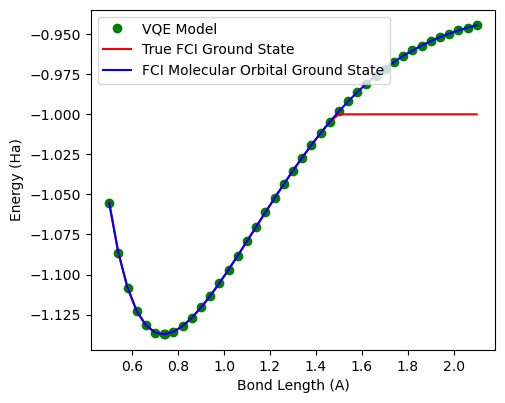

In [4]:
# This script calculates the ground state energy of the H2 molecule at many different bond lengths (chosen by the available bond
# lengths in the Pennylane library).  Data for the H2 molecule is obtained using the qml.data.load() function of Pennylane.
# Note that once the ground state becomes greater than -1Ha (the ground state energy of two separate hydrogen atoms), the bond 
# becomes unstable and the model breaks down, as shown in the plot.

from pennylane import numpy as np
import pennylane as qml
# Define the bond lengths as appropriate from the Pennylane library
lengths = [0.5, 0.54, 0.58, 0.62, 0.66, 0.7, 0.74, 0.742, 0.78, 0.82, 0.86, 0.9, 0.94, 0.98, 1.02, 1.06, 1.1, 1.14, 1.18, 1.22, 1.26, 1.3, 1.34, 1.38, 1.42, 1.46, 1.5, 1.54, 1.58, 1.62, 1.66, 1.7, 1.74, 1.78, 1.82, 1.86, 1.9, 1.94, 1.98, 2.02, 2.06, 2.1]
energies = []
energies2=[]
energies3=[]
# Find the ground state energy for each bond length
for p in lengths:
    #Load molecular data and build appropriate hamiltonian
    dataset = qml.data.load("qchem", molname="H2", bondlength=p, basis="STO-3G")[0]
    H, qubits = dataset.hamiltonian, len(dataset.hamiltonian.wires)
    dev = qml.device("lightning.qubit", wires=qubits)
    electrons = 2
    hf = qml.qchem.hf_state(electrons, qubits)
    #Define the circuit using the HF state and a double excitation gate
    def circuit(param, wires):
        qml.BasisState(hf, wires=wires)
        qml.DoubleExcitation(param, wires=[0, 1, 2, 3])
    @qml.qnode(dev, interface="autograd")
    # Define the cost function as the expectation value of the hamiltonian
    def cost_fn(param):
        circuit(param, wires=range(qubits))
        return qml.expval(H)
    # Define the optimization algorithm
    opt = qml.GradientDescentOptimizer(stepsize=0.4)
    theta = np.array(0.0, requires_grad=True)
    # store the values of the cost function
    energy = [cost_fn(theta)]


    # store the values of the circuit parameter
    angle = [theta]

    max_iterations = 100
    conv_tol = 1e-6
    # Optimize the circuit parameter

    for n in range(max_iterations):
        theta, prev_energy = opt.step_and_cost(cost_fn, theta)

        energy.append(cost_fn(theta))
        angle.append(theta)

        conv = np.abs(energy[-1] - prev_energy)
        if conv <= conv_tol:
            break
    energies.append(energy[-1])
    energies3.append(energy[-1])
    if dataset.fci_energy<-1:
        energies2.append(dataset.fci_energy)
    else:
        energies2.append(-1)


import matplotlib.pyplot as plt
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(12)



#Plot results
integer_array = [i for i in range(1, 43)]

ax3 = fig.add_subplot(122)
ax3.plot(lengths, energies, "go", label='VQE Model')
ax3.plot(lengths, energies2, "r-", label='True FCI Ground State')
ax3.plot(lengths, energies3, "b", label='FCI Molecular Orbital Ground State')
ax3.set_xlabel("Bond Length (A)")
ax3.set_ylabel("Energy (Ha)")


plt.subplots_adjust(wspace=0.3, bottom=0.2)
plt.legend()
plt.show()

Number of qubits =  4
Step = 0,  Energy = -1.12799983 Ha
Step = 2,  Energy = -1.13466246 Ha
Step = 4,  Energy = -1.13590595 Ha
Step = 6,  Energy = -1.13613667 Ha
Step = 8,  Energy = -1.13617944 Ha
Step = 10,  Energy = -1.13618736 Ha
Step = 12,  Energy = -1.13618883 Ha

Final value of the ground-state energy = -1.13618883 Ha

Optimal value of the circuit parameter = 0.2089


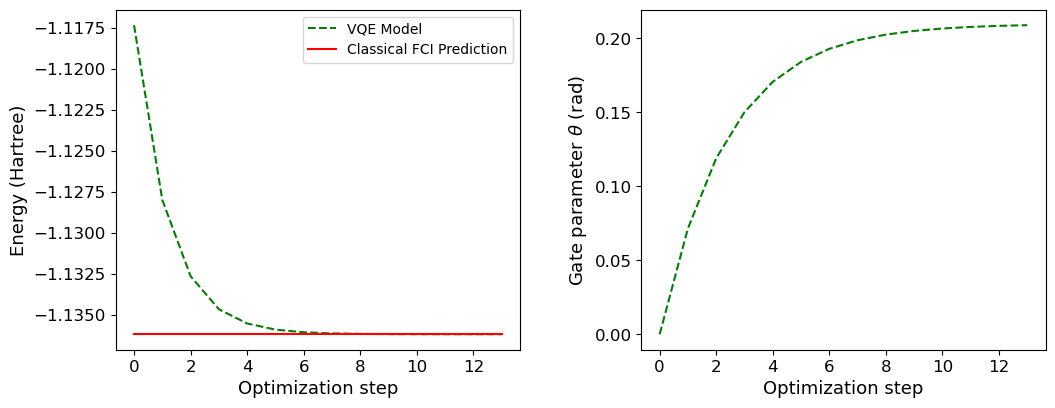

In [3]:
# This script calculates the ground state energy of the H2 molecule by manually specifying the characteristics (such as type of 
# atom an bond length) of the molecule.  Bond length is chosen to be the length that minimizes ground state energy in the FCI 
# model.  Optimization is done by adjusting just one circuit parameter, theta.
from pennylane import numpy as np
import pennylane as qml

# Manually define the characteristics of the H2 molecule 
symbols = ["H", "H"]
coordinates = np.array([0.0, 0.0, -0.6614, 0.0, 0.0, 0.6614])
# Define an appropriate hamiltonian, and assemble quantum circuit as two double excitation gates
H, qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates)
print("Number of qubits = ", qubits)
dev = qml.device("lightning.qubit", wires=qubits)
electrons = 2
hf = qml.qchem.hf_state(electrons, qubits)
def circuit(param, wires):
    qml.BasisState(hf, wires=wires)
    qml.DoubleExcitation(param, wires=[0, 1, 2, 3])
@qml.qnode(dev, interface="autograd")
# Define the cost function to be the expectation value of the hamiltonian for a given circuit parameter.
def cost_fn(param):
    circuit(param, wires=range(qubits))
    return qml.expval(H)
# Define the (classical) optimization method
opt = qml.GradientDescentOptimizer(stepsize=0.4)
theta = np.array(0.0, requires_grad=True)
energy = [cost_fn(theta)]
angle = [theta]
max_iterations = 100
conv_tol = 1e-06
# Perform iterations to find ground state energy
for n in range(max_iterations):
    theta, prev_energy = opt.step_and_cost(cost_fn, theta)
    energy.append(cost_fn(theta))
    angle.append(theta)
    conv = np.abs(energy[-1] - prev_energy)
    if n % 2 == 0:
        print(f"Step = {n},  Energy = {energy[-1]:.8f} Ha")
    if conv <= conv_tol:
        break
print("\n" f"Final value of the ground-state energy = {energy[-1]:.8f} Ha")
print("\n" f"Optimal value of the circuit parameter = {angle[-1]:.4f}")
# Plot results
import matplotlib.pyplot as plt

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(12)

# Full configuration interaction (FCI) energy computed classically
E_fci = -1.136189454088

# Add energy plot on column 1
ax1 = fig.add_subplot(121)
ax1.plot(range(n + 2), energy, "g", ls="dashed", label="VQE Model")
ax1.plot(range(n + 2), np.full(n + 2, E_fci), color="red", label="Classical FCI Prediction")
ax1.set_xlabel("Optimization step", fontsize=13)
ax1.set_ylabel("Energy (Hartree)", fontsize=13)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()

# Add angle plot on column 2
ax2 = fig.add_subplot(122)
ax2.plot(range(n + 2), angle, "g", ls="dashed")
ax2.set_xlabel("Optimization step", fontsize=13)
ax2.set_ylabel("Gate parameter $\\theta$ (rad)", fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplots_adjust(wspace=0.3, bottom=0.2)
plt.show()